In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import linregress
from statsmodels.api import OLS, add_constant

# === Parameters ===
START_DATE = "2005-12-31"
END_DATE = "2025-07-31"
REBALANCE_MONTHS = [3, 6, 9, 12]  # Quarterly
TOP_N = 100  # Top 100 momentum stocks

# Step 1: Load NSE500 list
nse500 = pd.read_html("https://en.wikipedia.org/wiki/NIFTY_50", header=0)[1]
symbols = nse500['Symbol'].tolist()

# Step 2: Download adjusted close price history
data = {}
for symbol in tqdm(symbols):
    try:
        df = yf.download(symbol + ".NS", start=START_DATE, end=END_DATE, interval="1d", progress=False)
        if df.empty or 'Close' not in df.columns:
            continue
        df = df[['Close']].rename(columns={'Close': symbol})
        data[symbol] = df
    except:
        continue

if not data:
    raise ValueError("No valid price data downloaded.")

prices = pd.concat(data.values(), axis=1)
prices.index = pd.to_datetime(prices.index)
prices = prices.dropna(axis=1, how='all')


prices

  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\amitt\AppData\Local\Temp\ipykernel_25952\4227290264.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol + ".NS", start=START_DATE, end=END_DATE, interval="1d", progress=False)
  2%|▏         | 1/50 [00:01<01:27,  1.79s/it]C:\Users\amitt\AppData\Local\Temp\ipykernel_25952\4227290264.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol + ".NS", start=START_DATE, end=END_DATE, interval="1d", progress=False)
  4%|▍         | 2/50 [00:02<00:50,  1.05s/it]C:\Users\amitt\AppData\Local\Temp\ipykernel_25952\4227290264.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol + ".NS", start=START_DATE, end=END_DATE, interval="1d", progress=False)
  6%|▌         | 3/50 [00:02<00:37,  1.27it/s]C:\Users\amitt\AppData\Local\Temp\ipykernel_25952\4227290264.py:23: FutureWarning: YF.downlo

Price,ADANIENT,ADANIPORTS,APOLLOHOSP,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJFINANCE,BAJAJFINSV,BEL,BHARTIARTL,...,SUNPHARMA,TCS,TATACONSUM,TATAMOTORS,TATASTEEL,TECHM,TITAN,TRENT,ULTRACEMCO,WIPRO
Ticker,ADANIENT.NS,ADANIPORTS.NS,APOLLOHOSP.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJFINANCE.NS,BAJAJFINSV.NS,BEL.NS,BHARTIARTL.NS,...,SUNPHARMA.NS,TCS.NS,TATACONSUM.NS,TATAMOTORS.NS,TATASTEEL.NS,TECHM.NS,TITAN.NS,TRENT.NS,ULTRACEMCO.NS,WIPRO.NS
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-02,3.578888,NaN,223.895782,47.873131,50.409935,313.918610,3.736514,1962.401611,7.271639,140.857346,...,55.032555,157.873260,69.148186,104.642998,18.934374,NaN,36.133202,64.754906,387.105530,47.494591
2006-01-03,3.620712,NaN,223.717758,48.230179,50.637245,315.719391,3.702060,1973.658813,7.310604,143.508392,...,55.020454,162.139084,69.905518,105.608345,19.294073,NaN,36.122410,65.461128,400.316406,48.657017
2006-01-04,3.641624,NaN,225.586899,47.913700,51.843731,321.145142,3.689152,2007.576660,7.291489,142.887070,...,55.016418,163.065216,70.011620,107.858116,19.196657,NaN,37.158623,66.153717,404.077820,49.490250
2006-01-05,3.614737,NaN,232.195602,47.877193,53.102673,324.041992,3.662153,2025.686157,7.252153,141.851501,...,54.512211,162.060516,69.590866,105.870125,19.004313,NaN,34.934944,66.360863,411.050140,48.765022
2006-01-06,3.641624,NaN,239.249313,47.925877,54.877426,320.479614,3.643517,2003.416748,7.273110,143.839798,...,54.826836,159.557114,69.166466,105.878311,19.194157,NaN,33.611969,66.478813,430.820618,48.626148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-14,2581.300049,1433.000000,7220.000000,2401.600098,1172.699951,8087.500000,918.849976,2003.599976,407.299988,1904.974609,...,1682.599976,3211.800049,1071.800049,674.500000,160.440002,1576.699951,3404.699951,5314.500000,12516.000000,254.250000
2025-07-15,2598.199951,1445.099976,7360.500000,2393.500000,1165.900024,8311.000000,928.400024,2036.500000,408.950012,1918.164307,...,1727.500000,3241.300049,1081.800049,684.400024,159.000000,1579.000000,3415.000000,5390.000000,12502.000000,257.399994


In [27]:
monthly_prices.to_excel("monthly_prices.xlsx")

In [2]:
# Step 3: Calculate momentum scores (12-month return)
monthly_prices = prices.resample('Q').last()
momentum_scores = pd.DataFrame(index=monthly_prices.index, columns=monthly_prices.columns)

for i in range(4, len(monthly_prices)):
    date = monthly_prices.index[i]
    past_returns = monthly_prices.iloc[i] / monthly_prices.iloc[i - 4] - 1
    momentum_scores.loc[date] = past_returns

momentum_scores

C:\Users\amitt\AppData\Local\Temp\ipykernel_25952\628799900.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  monthly_prices = prices.resample('Q').last()


Price,ADANIENT,ADANIPORTS,APOLLOHOSP,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJFINANCE,BAJAJFINSV,BEL,BHARTIARTL,...,SUNPHARMA,TCS,TATACONSUM,TATAMOTORS,TATASTEEL,TECHM,TITAN,TRENT,ULTRACEMCO,WIPRO
Ticker,ADANIENT.NS,ADANIPORTS.NS,APOLLOHOSP.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJFINANCE.NS,BAJAJFINSV.NS,BEL.NS,BHARTIARTL.NS,...,SUNPHARMA.NS,TCS.NS,TATACONSUM.NS,TATAMOTORS.NS,TATASTEEL.NS,TECHM.NS,TITAN.NS,TRENT.NS,ULTRACEMCO.NS,WIPRO.NS
Date,,,,,,,,,,,,,,,,,,,,,
2006-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-03-31,2.662902,NaN,0.001254,0.219158,0.391412,-0.116031,-0.119628,-0.116031,0.149645,0.850757,...,0.245972,0.300652,-0.288088,-0.205304,-0.23999,NaN,0.01243,-0.245876,0.139063,-0.000536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-30,0.299604,0.762605,0.404646,0.065209,0.189496,1.457944,-0.013795,0.282029,1.082309,0.855653,...,0.677666,0.224469,0.37439,0.546573,0.333948,0.327885,0.218389,2.643895,0.438184,0.3363
2024-12-31,-0.112069,0.206992,0.282263,-0.32184,-0.033365,0.304955,-0.068882,-0.069232,0.607571,0.546792,...,0.511072,0.092484,-0.152552,-0.051029,0.008821,0.37777,-0.112001,1.33334,0.094359,0.283657


In [3]:
# Step 4: Backtest quarterly rebalancing
portfolio_returns = []
benchmark_returns = []
bottom10_cumulative = []

for i in range(4, len(momentum_scores)):
    date = momentum_scores.index[i]
    if date.month not in REBALANCE_MONTHS:
        continue

    scores = momentum_scores.loc[date].dropna()
    top_stocks = scores.sort_values(ascending=False).head(int(len(scores)*0.1)).index
    bottom10 = scores.sort_values(ascending=True).head(int(len(scores)*0.1)).index

    try:
        next_date = momentum_scores.index[i + 1]
    except IndexError:
        break

    try:
        next_returns = monthly_prices.loc[next_date, top_stocks] / monthly_prices.loc[date, top_stocks] - 1
        portfolio_returns.append((next_date, next_returns.mean()))

        bottom10_returns = monthly_prices.loc[next_date, bottom10] / monthly_prices.loc[date, bottom10] - 1
        bottom10_cumulative.append((next_date, bottom10_returns.mean()))
    except:
        continue

perf_df = pd.DataFrame(portfolio_returns, columns=["Date", "Return"]).set_index("Date")
perf_df["Cumulative"] = (1 + perf_df["Return"]).cumprod()

bottom10_df = pd.DataFrame(bottom10_cumulative, columns=["Date", "Return"]).set_index("Date")
bottom10_df["Cumulative"] = (1 + bottom10_df["Return"]).cumprod()



In [33]:
#error check code
rebalance_log = []
for i in range(4, len(momentum_scores)):
    date = momentum_scores.index[i]
    if date.month not in REBALANCE_MONTHS:
        continue

    scores = momentum_scores.loc[date].dropna()
    top_stocks = scores.sort_values(ascending=False).head(int(len(scores) * 0.1)).index
    bottom10 = scores.sort_values(ascending=True).head(int(len(scores) * 0.1)).index

    try:
        next_date = momentum_scores.index[i + 1]
    except IndexError:
        break

    try:
        next_returns = monthly_prices.loc[next_date, top_stocks] / monthly_prices.loc[date, top_stocks] - 1
        portfolio_returns.append((next_date, next_returns.mean()))

        bottom10_returns = monthly_prices.loc[next_date, bottom10] / monthly_prices.loc[date, bottom10] - 1
        bottom10_cumulative.append((next_date, bottom10_returns.mean()))

        rebalance_log.append({
            "Rebalance_Date": date,
            "Top_Stocks": top_stocks.tolist(),
            "Top_Returns": next_returns.to_dict(),
            "Bottom_Stocks": bottom10.tolist(),
            "Bottom_Returns": bottom10_returns.to_dict()
        })
    except:
        continue

perf_df = pd.DataFrame(portfolio_returns, columns=["Date", "Return"]).set_index("Date")
perf_df["Cumulative"] = (1 + perf_df["Return"]).cumprod()

bottom10_df = pd.DataFrame(bottom10_cumulative, columns=["Date", "Return"]).set_index("Date")
bottom10_df["Cumulative"] = (1 + bottom10_df["Return"]).cumprod()

In [35]:
# rebalance_df = pd.DataFrame(rebalance_log)
# rebalance_df.to_excel("quarterly_top_bottom_returns.xlsx", index=False)

In [25]:
perf_df

,Return,Cumulative
Date,,
2007-06-30,0.220418,1.220418
2007-09-30,0.281725,1.564240
2007-12-31,0.625747,2.543059
2008-03-31,-0.386250,1.560803
2008-06-30,-0.096967,1.409456
...,...,...
2024-09-30,0.146609,111.878326
2024-12-31,-0.086761,102.171680
2025-03-31,-0.060160,96.025052


In [4]:
# Step 5: Compute performance stats
nav = perf_df["Cumulative"]
rolling_max = nav.cummax()
drawdown = (nav - rolling_max) / rolling_max
max_drawdown = drawdown.min()
volatility = perf_df["Return"].std() * np.sqrt(4)  # Quarterly to annual
sharpe = perf_df["Return"].mean() / perf_df["Return"].std() * np.sqrt(4)

# Alpha vs linear time trend
x = np.arange(len(perf_df))
y = np.log(perf_df["Cumulative"])
slope, intercept, r_value, p_value, std_err = linregress(x, y)
alpha = slope * 4  # Quarterly to annual

# Alpha vs benchmark using CAPM-style regression
benchmark = yf.download("^NSEI", start=START_DATE, end=END_DATE, interval="1D")["Close"].resample("Q").last()
benchmark_ret = benchmark.pct_change().reindex(perf_df.index)
strategy_ret = perf_df["Return"]
risk_free_rate = 7.0  # Assuming 0 for now

excess_return = strategy_ret - risk_free_rate
excess_benchmark = benchmark_ret - risk_free_rate

X = add_constant(excess_benchmark.dropna())
model = OLS(excess_return.loc[X.index], X).fit()
capm_alpha = model.params['const']

# Jensen's Alpha (same as CAPM alpha here, but naming for clarity)
jensens_alpha = capm_alpha



C:\Users\amitt\AppData\Local\Temp\ipykernel_25952\692571311.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  benchmark = yf.download("^NSEI", start=START_DATE, end=END_DATE, interval="1D")["Close"].resample("Q").last()
[*********************100%***********************]  1 of 1 completed
C:\Users\amitt\AppData\Local\Temp\ipykernel_25952\692571311.py:16: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  benchmark = yf.download("^NSEI", start=START_DATE, end=END_DATE, interval="1D")["Close"].resample("Q").last()


In [5]:
benchmark

Ticker,^NSEI
Date,
2007-09-30,5021.350098
2007-12-31,6138.600098
2008-03-31,4734.500000
2008-06-30,4040.550049
2008-09-30,3921.199951
...,...
2024-09-30,25810.849609
2024-12-31,23644.800781
2025-03-31,23519.349609


In [6]:
# benchmark_ret.to_csv("niftyfy.csv")
# perf_df["Cumulative"]

In [7]:
# perf_df["Cumulative"].to_csv("pmfy.csv")

In [8]:
nifty_rtn = (1 + benchmark_ret).cumprod()
nifty_rtn

Ticker,^NSEI
Date,
2007-06-30,NaN
2007-09-30,NaN
2007-12-31,1.222500
2008-03-31,0.942874
2008-06-30,0.804674
...,...
2024-09-30,5.140221
2024-12-31,4.708853
2025-03-31,4.683870


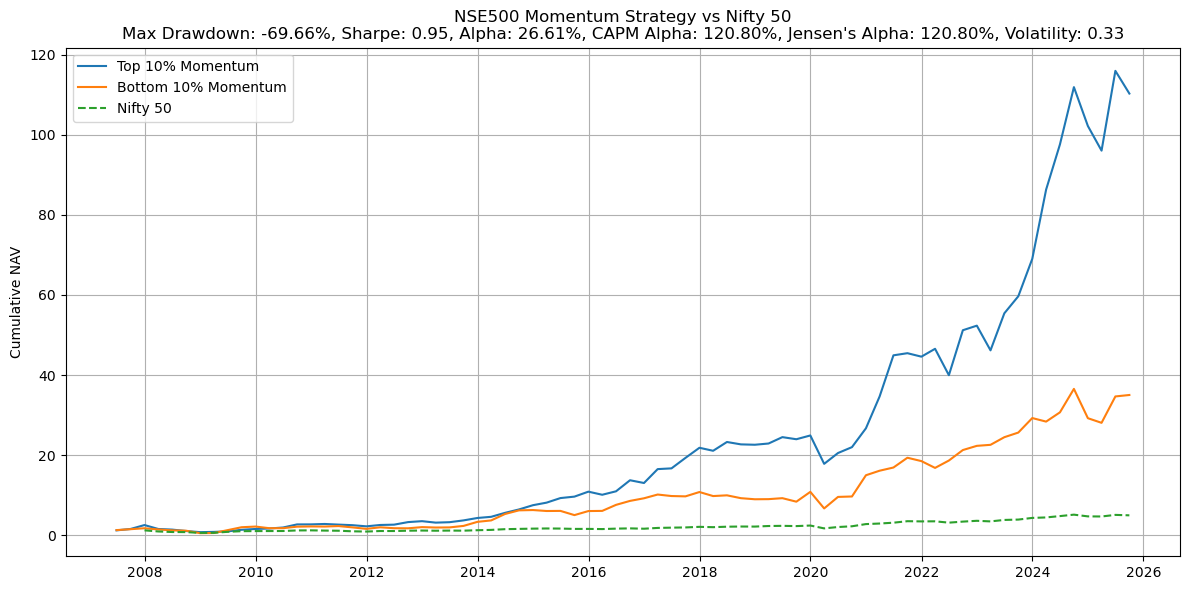

In [9]:
# Step 6: Plot
plt.figure(figsize=(12, 6))
plt.plot(perf_df["Cumulative"], label="Top 10% Momentum")
plt.plot(bottom10_df["Cumulative"], label="Bottom 10% Momentum")
plt.plot((1 + benchmark_ret).cumprod(), label="Nifty 50", linestyle='--')
plt.title(f"NSE500 Momentum Strategy vs Nifty 50\nMax Drawdown: {max_drawdown:.2%}, Sharpe: {sharpe:.2f}, Alpha: {alpha:.2%}, CAPM Alpha: {capm_alpha:.2%}, Jensen's Alpha: {jensens_alpha:.2%}, Volatility: {volatility:.2f}")
plt.ylabel("Cumulative NAV")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Export
# perf_df.to_csv("momentum_strategy_nse500.csv")

In [ ]:
#Complete code

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import linregress
from statsmodels.api import OLS, add_constant

# === Parameters ===
START_DATE = "2005-12-31"
END_DATE = "2025-07-31"
REBALANCE_MONTHS = [3, 6, 9, 12]  # Quarterly

# Step 1: Load NSE500 list
nse500 = pd.read_html("https://en.wikipedia.org/wiki/NIFTY_50", header=0)[4]
symbols = nse500['Symbol'].tolist()

# Step 2: Download adjusted close price history
data = {}
for symbol in tqdm(symbols):
    try:
        df = yf.download(symbol + ".NS", start=START_DATE, end=END_DATE, interval="1mo", progress=False)
        if df.empty or 'Adj Close' not in df.columns:
            continue
        df = df[['Adj Close']].rename(columns={'Adj Close': symbol})
        data[symbol] = df
    except:
        continue

if not data:
    raise ValueError("No valid price data downloaded.")

prices = pd.concat(data.values(), axis=1)
prices.index = pd.to_datetime(prices.index)
prices = prices.dropna(axis=1, how='all')

# Step 3: Calculate momentum scores (12-month return)
monthly_prices = prices.resample('Q').last()
momentum_scores = pd.DataFrame(index=monthly_prices.index, columns=monthly_prices.columns)

for i in range(4, len(monthly_prices)):
    date = monthly_prices.index[i]
    past_returns = monthly_prices.iloc[i] / monthly_prices.iloc[i - 4] - 1
    momentum_scores.loc[date] = past_returns

# Step 4: Backtest quarterly rebalancing
portfolio_returns = []
benchmark_returns = []
bottom10_cumulative = []
rebalance_log = []  # Store top/bottom stocks and their returns

for i in range(4, len(momentum_scores)):
    date = momentum_scores.index[i]
    if date.month not in REBALANCE_MONTHS:
        continue

    scores = momentum_scores.loc[date].dropna()
    top_stocks = scores.sort_values(ascending=False).head(int(len(scores) * 0.1)).index
    bottom10 = scores.sort_values(ascending=True).head(int(len(scores) * 0.1)).index

    try:
        next_date = momentum_scores.index[i + 1]
    except IndexError:
        break

    try:
        next_returns = monthly_prices.loc[next_date, top_stocks] / monthly_prices.loc[date, top_stocks] - 1
        portfolio_returns.append((next_date, next_returns.mean()))

        bottom10_returns = monthly_prices.loc[next_date, bottom10] / monthly_prices.loc[date, bottom10] - 1
        bottom10_cumulative.append((next_date, bottom10_returns.mean()))

        rebalance_log.append({
            "Rebalance_Date": date,
            "Top_Stocks": top_stocks.tolist(),
            "Top_Returns": next_returns.to_dict(),
            "Bottom_Stocks": bottom10.tolist(),
            "Bottom_Returns": bottom10_returns.to_dict()
        })
    except:
        continue

perf_df = pd.DataFrame(portfolio_returns, columns=["Date", "Return"]).set_index("Date")
perf_df["Cumulative"] = (1 + perf_df["Return"]).cumprod()

bottom10_df = pd.DataFrame(bottom10_cumulative, columns=["Date", "Return"]).set_index("Date")
bottom10_df["Cumulative"] = (1 + bottom10_df["Return"]).cumprod()

# Step 5: Benchmark returns
benchmark = yf.download("^NSEI", start=START_DATE, end=END_DATE, interval="1mo")['Adj Close'].resample('Q').last()
benchmark_ret = benchmark.pct_change().dropna()
benchmark_cum = (1 + benchmark_ret).cumprod()

# Step 6: Plot
plt.figure(figsize=(14, 7))
plt.plot(perf_df["Cumulative"], label="Top 10% Momentum")
plt.plot(bottom10_df["Cumulative"], label="Bottom 10% Momentum")
plt.plot(benchmark_cum, label="Nifty 50", linestyle='--', color='black')
plt.title("Momentum Strategy: Top vs Bottom 10% vs Nifty 50")
plt.ylabel("Cumulative NAV")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 7: Export Rebalance Details
rebalance_df = pd.DataFrame(rebalance_log)
rebalance_df.to_excel("quarterly_top_bottom_returns.xlsx", index=False)


In [ ]:
# code for quantiles

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import linregress
from statsmodels.api import OLS, add_constant

# === Parameters ===
START_DATE = "2005-12-31"
END_DATE = "2025-07-31"
REBALANCE_MONTHS = [3, 6, 9, 12]  # Quarterly
NUM_QUANTILES = 5

# Step 1: Load NSE500 list
nse500 = pd.read_html("https://en.wikipedia.org/wiki/NIFTY_50", header=0)[4]
symbols = nse500['Symbol'].tolist()

# Step 2: Download adjusted close price history
data = {}
for symbol in tqdm(symbols):
    try:
        df = yf.download(symbol + ".NS", start=START_DATE, end=END_DATE, interval="1mo", progress=False)
        if df.empty or 'Adj Close' not in df.columns:
            continue
        df = df[['Adj Close']].rename(columns={'Adj Close': symbol})
        data[symbol] = df
    except:
        continue

if not data:
    raise ValueError("No valid price data downloaded.")

prices = pd.concat(data.values(), axis=1)
prices.index = pd.to_datetime(prices.index)
prices = prices.dropna(axis=1, how='all')

# Step 3: Calculate momentum scores (12-month return)
monthly_prices = prices.resample('Q').last()
momentum_scores = pd.DataFrame(index=monthly_prices.index, columns=monthly_prices.columns)

for i in range(4, len(monthly_prices)):
    date = monthly_prices.index[i]
    past_returns = monthly_prices.iloc[i] / monthly_prices.iloc[i - 4] - 1
    momentum_scores.loc[date] = past_returns

# Step 4: Backtest using quantile portfolios
quantile_returns = {q: [] for q in range(NUM_QUANTILES)}
benchmark_returns = []

for i in range(13, len(momentum_scores)):
    date = momentum_scores.index[i]
    if date.month not in REBALANCE_MONTHS:
        continue

    scores = momentum_scores.loc[date].dropna()
    try:
        next_date = momentum_scores.index[i + 1]
    except IndexError:
        break

    quantiles = pd.qcut(scores, NUM_QUANTILES, labels=False)
    for q in range(NUM_QUANTILES):
        quantile_stocks = scores[quantiles == q].index
        try:
            next_returns = monthly_prices.loc[next_date, quantile_stocks] / monthly_prices.loc[date, quantile_stocks] - 1
            quantile_returns[q].append((next_date, next_returns.mean()))
        except:
            continue

benchmark = yf.download("^NSEI", start=START_DATE, end=END_DATE, interval="1mo")['Adj Close'].resample('Q').last()
benchmark_ret = benchmark.pct_change().dropna()

# Step 5: Create DataFrames and compute cumulative returns
quantile_dfs = {}
for q in range(NUM_QUANTILES):
    df = pd.DataFrame(quantile_returns[q], columns=["Date", "Return"]).set_index("Date")
    df["Cumulative"] = (1 + df["Return"]).cumprod()
    quantile_dfs[q] = df

benchmark_cum = (1 + benchmark_ret).cumprod()

# Step 6: Plot all quantiles and benchmark
plt.figure(figsize=(14, 7))
for q in range(NUM_QUANTILES):
    plt.plot(quantile_dfs[q]["Cumulative"], label=f"Quantile {q+1}")

plt.plot(benchmark_cum, label="Nifty 50", linestyle='--', color='black')
plt.title("Momentum Strategy: 5 Quantiles vs Nifty 50")
plt.ylabel("Cumulative NAV")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
